# Toy Model for the stress intensity computation
We'll go through a few steps to make a "fake" ridge to test the routine and visualize simple outputs.

In [17]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib import cm
from math import floor,sqrt
import pygmt
%matplotlib inline

## Step one: create a fake topography grid...

In [2]:
n = 4096
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
X,Y = np.meshgrid(x,y)
Z = np.zeros_like(X)
X.shape

(4096, 4096)

### Simplified ridge topography
I'm modeling this ridge topography after the simplified Galapagos ridge topography shown in Phipps Morgan and Parmentier (1985).

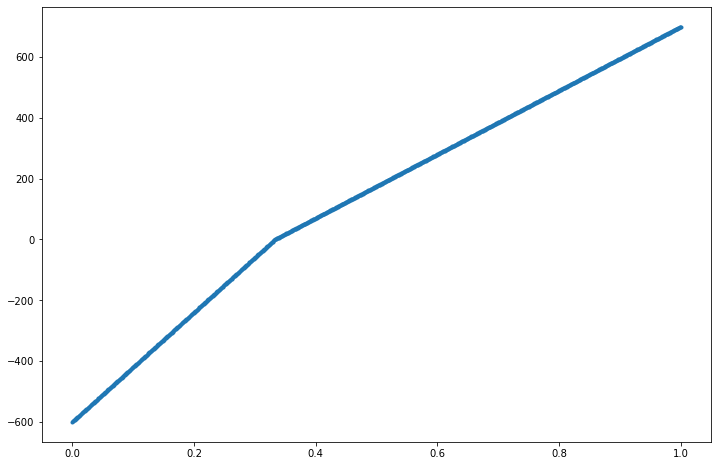

In [10]:
# central ridge profile:
seg1 = floor(n/3.)
seg1_slope = 600./x[seg1]
seg2_slope = 700./x[n-seg1]
r = np.zeros_like(x)
r[:seg1] = -600 + seg1_slope*x[:seg1]
r[seg1:] = seg2_slope*(x[seg1:] - x[seg1])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,r,'.')

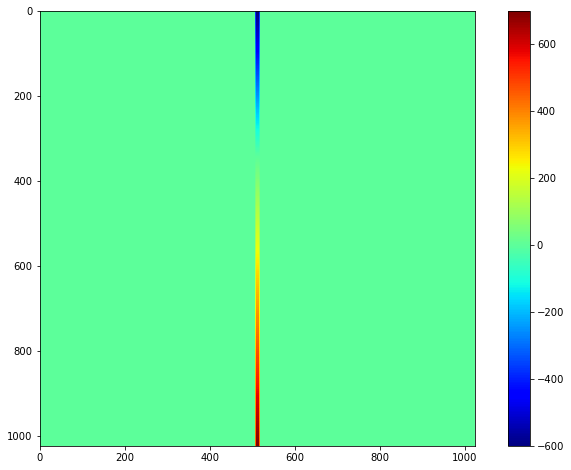

In [11]:
# make the central columns of this grid the ridge profile
mid = floor(n/2.)
Z[:,(mid-5):(mid+5)] = np.tile(r,(10,1)).transpose()
fig, ax = plt.subplots(figsize=(12,8))
cset = ax.imshow(Z, cmap=cm.jet)
fig.colorbar(cset,ax=ax)
plt.show()

So this grid, to be acceptable as bathymetry, probably needs a few more tweaks. One, the base depth should be something like -1000 or so, so we could easily just subtract that constant from the grid. Another issue is the abruptness of the topography-- the ridge is basically a step function increase. We'd probably like to smooth that out, and we could do that with a filter (try it).

Another note-- pyplot imshow() shows the flipped grid relative to what we'll see with gmt (i.e., the ridge high is in the "north" and the low in the "south").

We'll also want to grab the "lon/lat" coords along the ridge so we can sample the stress grids (cell below).

In [5]:
#np.savetxt('toy_ridge.txt',np.column_stack((X[:,1024],Y[:,1024])),fmt='%.10f',delimiter='\t')

### Circle load
A simple circle-shaped load is a good test for evaluating the results

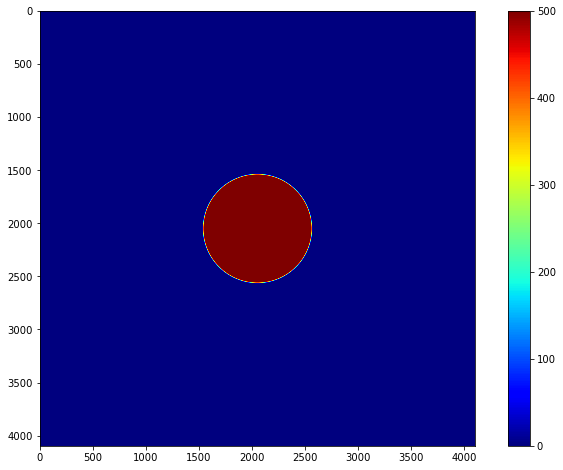

In [3]:
Z = np.zeros_like(X)
Z[(X - 0.5)**2 + (Y - 0.5)**2 < 0.125**2] = 500
fig, ax = plt.subplots(figsize=(12,8))
cset = ax.imshow(Z, cmap=cm.jet)
fig.colorbar(cset,ax=ax)
plt.show()

## Export this as a netcdf (testing...)
~Problem: writegrd produces a netcdf-4 version, and the scipy module i'm using is netcdf-3. need to do a conversion if reading them that way.~
Using the netCDF4 module, we can write the grid to netcdf.

A note-- for the GMT tools to work, some netcdf metadata is necessary...

In [4]:
from ridgetools import write_GMT_netcdf, read_GMT_netcdf

In [5]:
write_GMT_netcdf('toymodel.nc',np.linspace(0,1,n),np.linspace(0,1,n),Z)

## read in the netcdf we just created (testing...)

In [16]:
lons, lats, Z2 = read_GMT_netcdf('toymodel.nc')
print(lons)

[0.00000000e+00 9.77517107e-04 1.95503421e-03 ... 9.98044966e-01
 9.99022483e-01 1.00000000e+00]


## Use pygmt tools to examine the new netcdf file

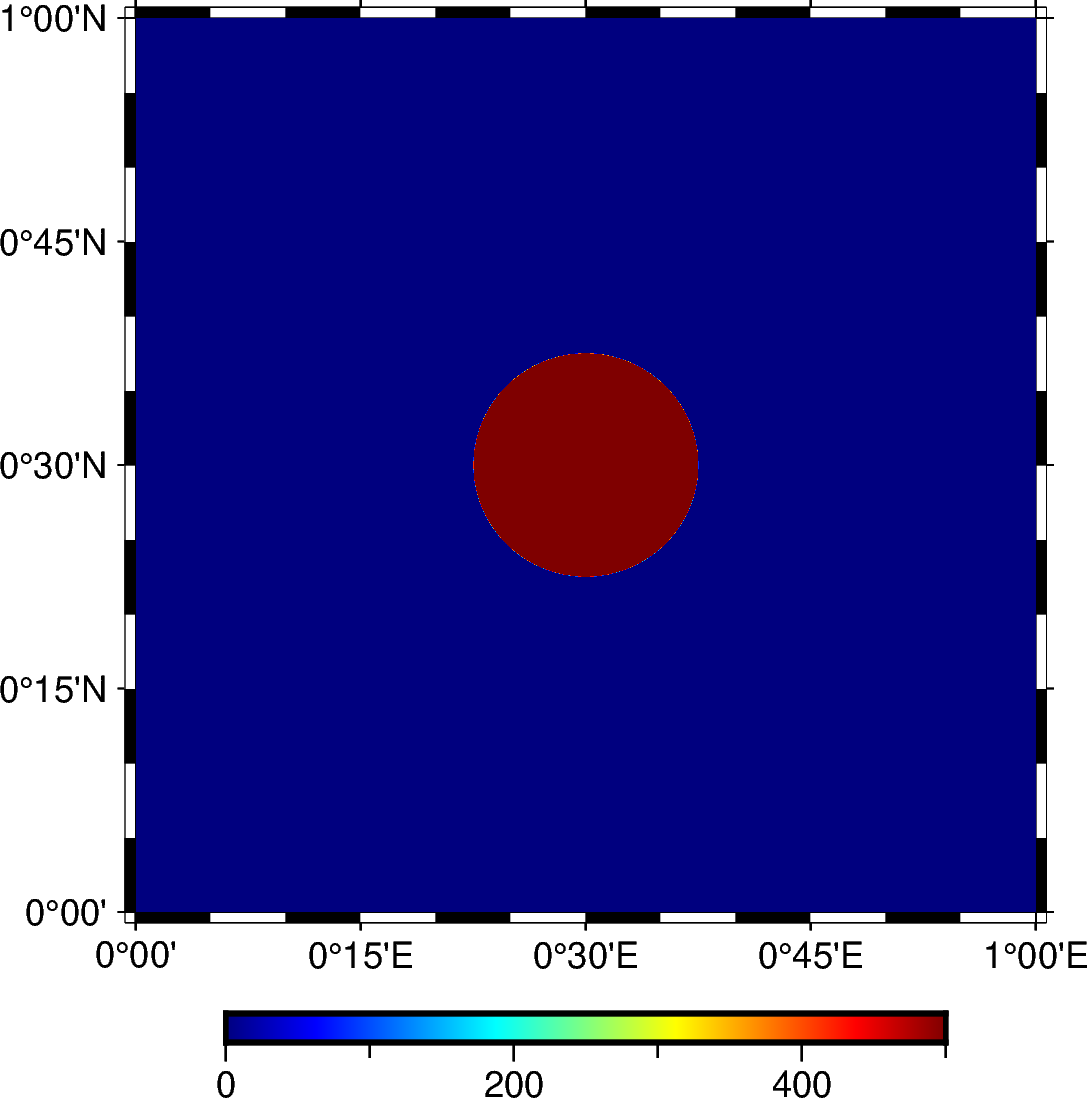

In [6]:
fig = pygmt.Figure()
fig.basemap(region=[0,1,0,1],projection="M3i",frame=True)
fig.grdimage(grid='toymodel.nc',cmap='jet')
fig.colorbar()
fig.show()

Looks like it's all working!

## Tweak the fake topography by filtering it

We could've done this before saving to a netcdf file.

In [ ]:
pygmt.grdfilter(
    grid='toymodel.nc',
    filter="g101",
    distance="p",
    outgrid="toymodel_filt.nc"
)

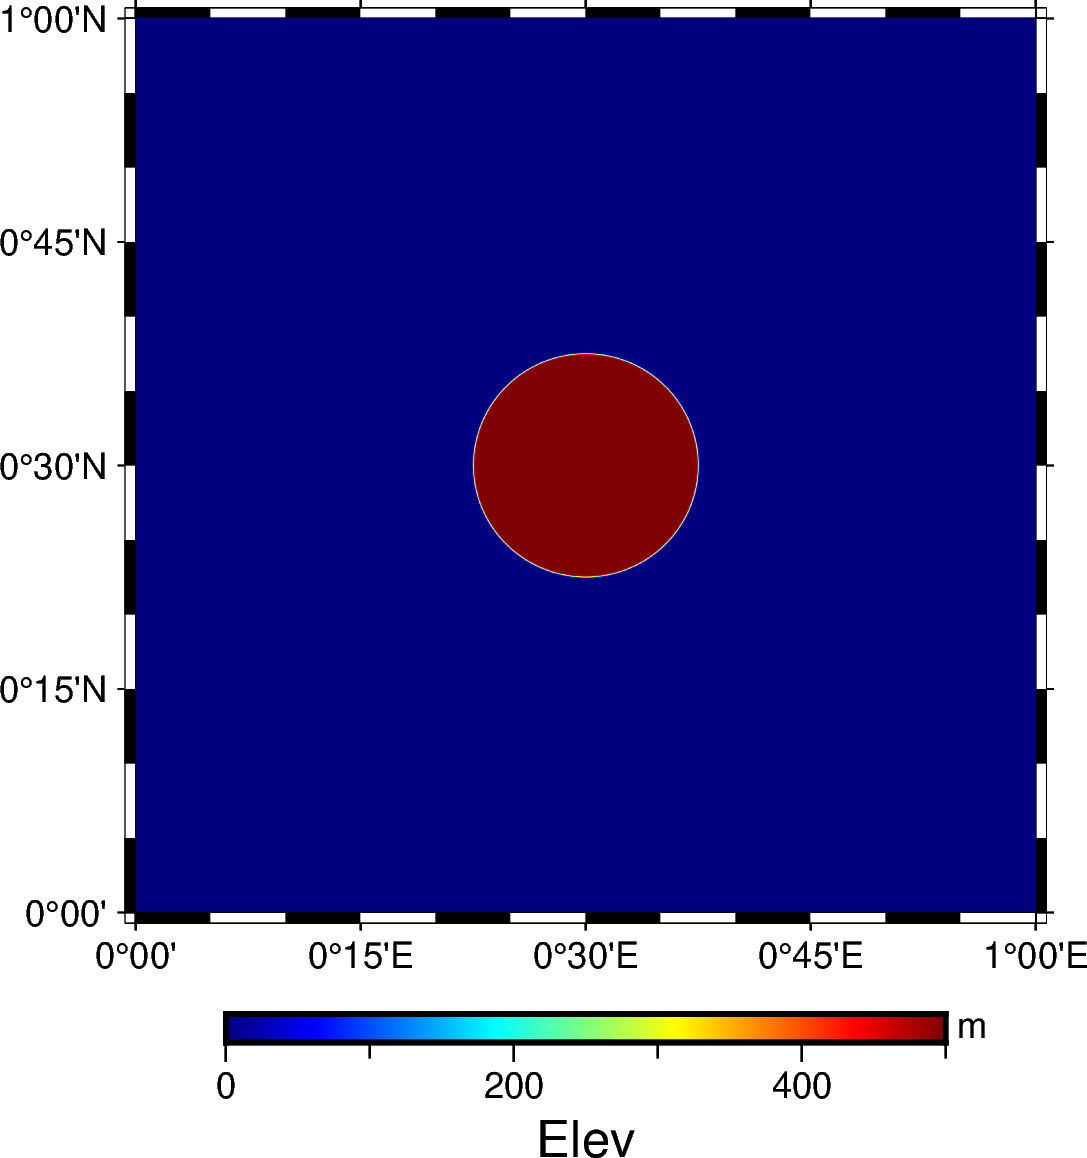

In [5]:
fig = pygmt.Figure()
fig.basemap(region=[0,1,0,1],projection="M3i",frame=True)
fig.grdimage(grid='toymodel_filt.nc',cmap='jet')
fig.colorbar(
    frame=['x+lElev','y+lm'],
)
fig.show()

# Visualize some of the generated stress grids
These grids are computed from the "unfiltered" topography (toymodel.nc).
## Txx, 0.5 km depth
horizontal normal stress, x-direction (side-side in map view)

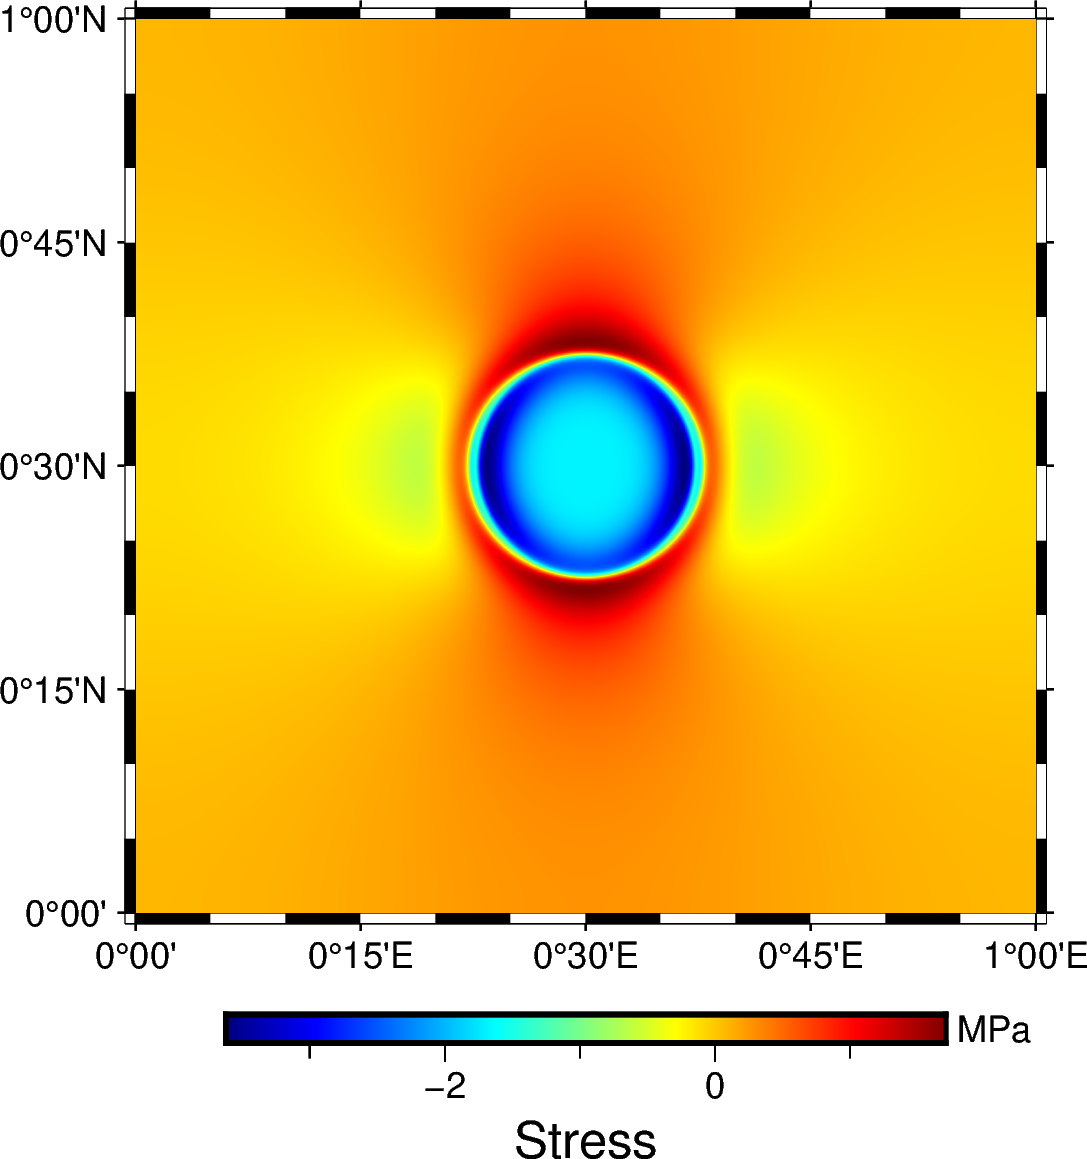

In [6]:
fig = pygmt.Figure()
fig.basemap(region=[0,1,0,1],projection="M3i",frame=True)
fig.grdimage(grid='toy_stress_grds/Txx.nc',cmap='jet')
fig.colorbar(
    frame=['x+lStress','y+lMPa'],
    scale=1e-6
)
fig.show()

### Tyy, 0.5 km depth
Horizontal normal stress, y direction (up-down in map view)

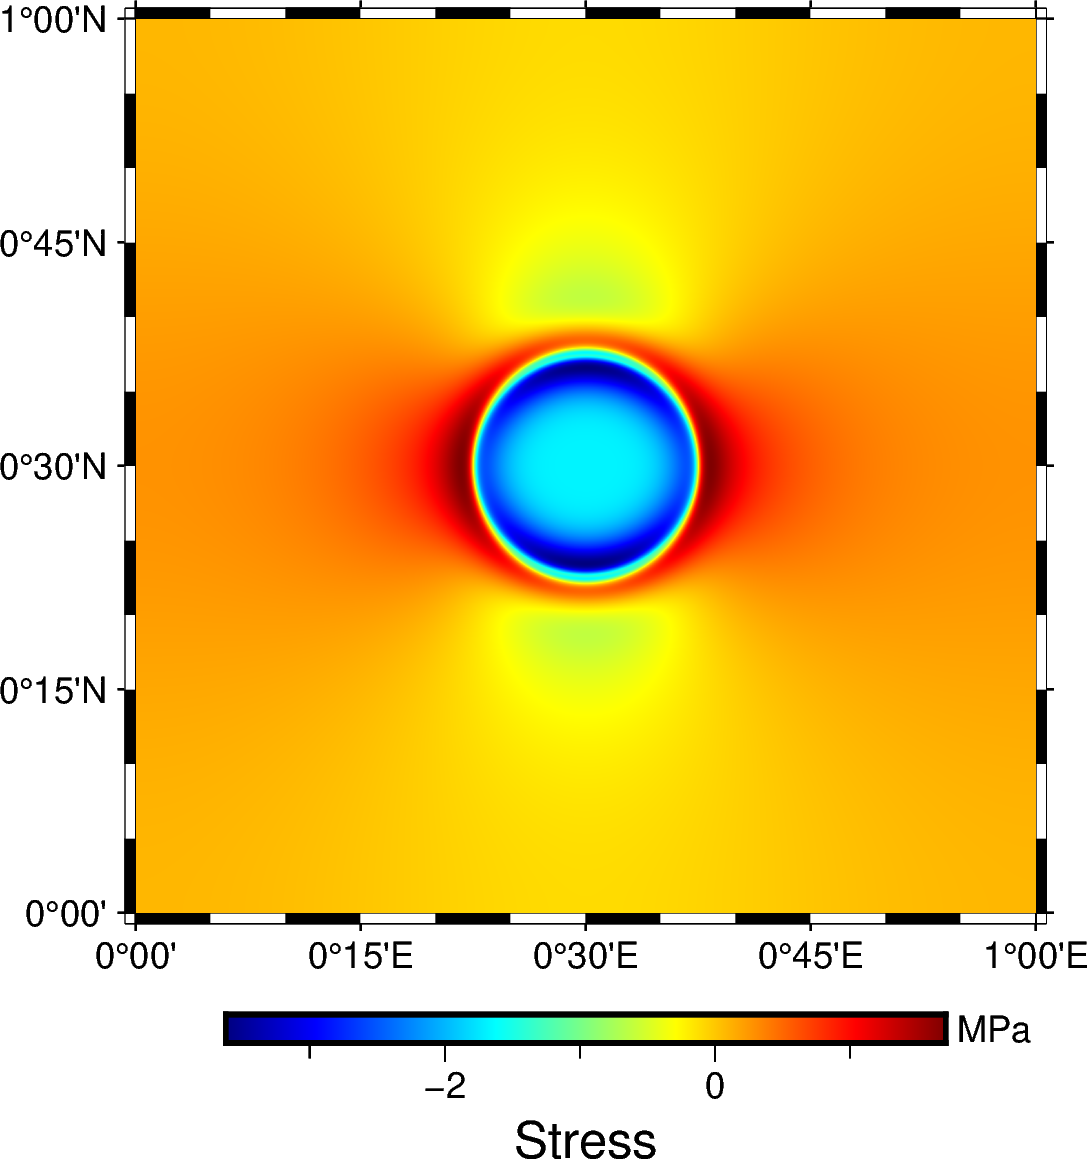

In [7]:
fig = pygmt.Figure()
fig.basemap(region=[0,1,0,1],projection="M3i",frame=True)
fig.grdimage(grid='toy_stress_grds/Tyy.nc',cmap='jet')
fig.colorbar(
    frame=['x+lStress','y+lMPa'],
    scale=1e-6
)
fig.show()

## Sampling the ridge on the stress grids
The stress grids are computed on cryosat with the routine topo_stress_grd. The stress values are extracted along the points defined by the ridge.

In [3]:
from ridgetools import *

region = 'toy'
oneTable = get_table_for_region(region,fromIMG=False)

print(oneTable)

           lon  lat  strike  dep  migration              K
toy_ridge  0.0  0.0     0.0  0.0        0.0 -544884.905914


# Goofing off w/ FFT stuff

In [5]:
from scipy.fft import fft2,ifft2,fftshift,ifftshift,fftfreq

def fft_grd(to_fft, inv=False):
    if inv==True:
        out = ifft2(ifftshift(to_fft))
    else:
        out = fftshift(fft2(to_fft))
        kx = fftshift(fftfreq(to_fft.shape[0]))
        ky = fftshift(fftfreq(to_fft.shape[-1]))
    return out, kx, ky

In [10]:
Zk, kx, ky = fft_grd(Z)

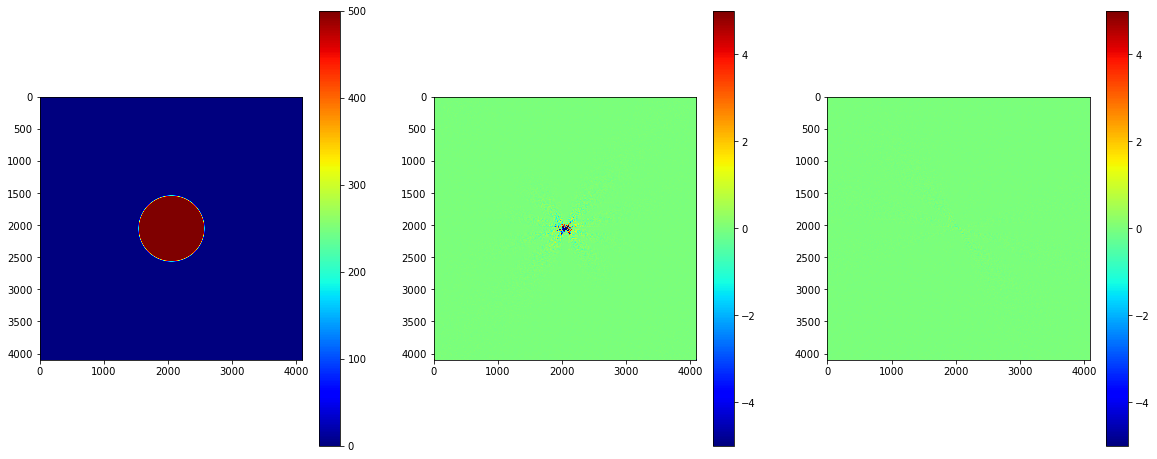

In [34]:
fig, ax = plt.subplots(1,3,figsize=(20,8))
cset1 = ax[0].imshow(Z, cmap=cm.jet)
fig.colorbar(cset1,ax=ax[0])
cset2 = ax[1].imshow(Zk.real, cmap=cm.jet)
fig.colorbar(cset2,ax=ax[1])
cset2.set_clim(-5,5)
cset3 = ax[2].imshow(Zk.imag, cmap=cm.jet)
fig.colorbar(cset3,ax=ax[2])
cset3.set_clim(-5,5)
plt.show()

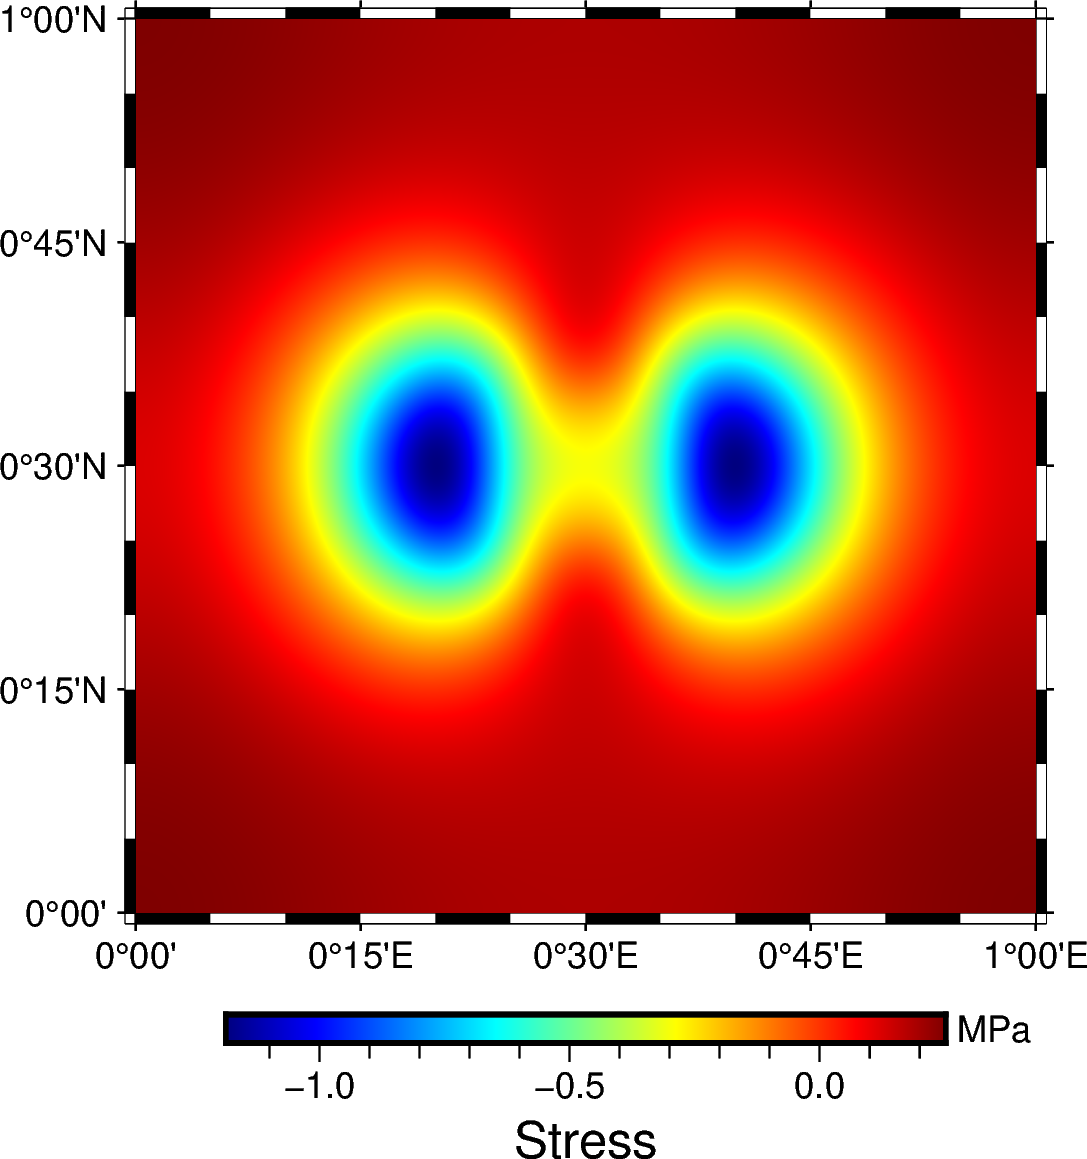

In [22]:
fig = pygmt.Figure()
fig.basemap(region=[0,1,0,1],projection="M3i",frame=True)
fig.grdimage(grid='Txx-temp.nc',cmap='jet')
fig.colorbar(
    frame=['x+lStress','y+lMPa'],
    scale=1e-6
)
fig.show()